In [450]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

msft = yf.Ticker("UNH")
print(msft)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


yfinance.Ticker object <UNH>


In [451]:
msft.info

{'address1': 'UnitedHealth Group Center',
 'address2': '9900 Bren Road East',
 'city': 'Minnetonka',
 'state': 'MN',
 'zip': '55343',
 'country': 'United States',
 'phone': '952 936 1300',
 'website': 'https://www.unitedhealthgroup.com',
 'industry': 'Healthcare Plans',
 'industryKey': 'healthcare-plans',
 'industryDisp': 'Healthcare Plans',
 'sector': 'Healthcare',
 'sectorKey': 'healthcare',
 'sectorDisp': 'Healthcare',
 'longBusinessSummary': "UnitedHealth Group Incorporated operates as a diversified health care company in the United States. The company operates through four segments: UnitedHealthcare, Optum Health, Optum Insight, and Optum Rx. The UnitedHealthcare segment offers consumer-oriented health benefit plans and services for national employers, public sector employers, mid-sized employers, small businesses, and individuals; health care coverage, and health and well-being services to individuals age 50 and older addressing their needs; Medicaid plans, children's health insu

In [452]:
df = msft.history(period="5y")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-12 00:00:00-04:00,242.807172,247.345348,242.807172,246.769958,5336100,0.0,0.0
2019-07-15 00:00:00-04:00,245.990394,248.394054,245.238671,246.825638,2611400,0.0,0.0
2019-07-16 00:00:00-04:00,246.240968,247.920774,244.254944,245.619186,3121600,0.0,0.0
2019-07-17 00:00:00-04:00,245.006662,249.359245,244.542634,247.466003,3995200,0.0,0.0
2019-07-18 00:00:00-04:00,246.528680,247.336084,238.751571,241.851273,5825800,0.0,0.0
...,...,...,...,...,...,...,...
2024-07-05 00:00:00-04:00,489.000000,489.670013,484.500000,488.010010,3499000,0.0,0.0
2024-07-08 00:00:00-04:00,489.190002,493.880005,486.170013,489.339996,3450600,0.0,0.0
2024-07-09 00:00:00-04:00,488.329987,495.399994,486.089996,492.109985,3056800,0.0,0.0


In [453]:
df = df[['Close']]
df

,Close
Date,
2019-07-12 00:00:00-04:00,246.769958
2019-07-15 00:00:00-04:00,246.825638
2019-07-16 00:00:00-04:00,245.619186
2019-07-17 00:00:00-04:00,247.466003
2019-07-18 00:00:00-04:00,241.851273
...,...
2024-07-05 00:00:00-04:00,488.010010
2024-07-08 00:00:00-04:00,489.339996
2024-07-09 00:00:00-04:00,492.109985


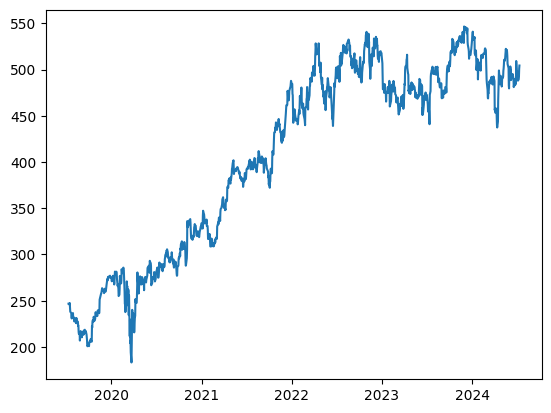

In [454]:
plt.plot(df.index, df['Close'])

In [455]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)


    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2019-07-23 00:00:00-04:00,236.663452,236.951141,238.185455,241.851273,247.466003,245.619186,246.825638,246.769958
2019-07-24 00:00:00-04:00,233.062561,236.663452,236.951141,238.185455,241.851273,247.466003,245.619186,246.825638
2019-07-25 00:00:00-04:00,230.807404,233.062561,236.663452,236.951141,238.185455,241.851273,247.466003,245.619186
2019-07-26 00:00:00-04:00,234.742386,230.807404,233.062561,236.663452,236.951141,238.185455,241.851273,247.466003
2019-07-29 00:00:00-04:00,235.559067,234.742386,230.807404,233.062561,236.663452,236.951141,238.185455,241.851273
...,...,...,...,...,...,...,...,...
2024-07-05 00:00:00-04:00,488.010010,489.890015,498.239990,494.649994,509.260010,486.440002,484.040009,484.500000
2024-07-08 00:00:00-04:00,489.339996,488.010010,489.890015,498.239990,494.649994,509.260010,486.440002,484.040009
2024-07-09 00:00:00-04:00,492.109985,489.339996,488.010010,489.890015,498.239990,494.649994,509.260010,486.440002


In [456]:
shifted_df_np = shifted_df.to_numpy()
shifted_df_np

array([[236.66345215, 236.95114136, 238.18545532, ..., 245.6191864 ,
        246.82563782, 246.7699585 ],
       [233.06256104, 236.66345215, 236.95114136, ..., 247.46600342,
        245.6191864 , 246.82563782],
       [230.80740356, 233.06256104, 236.66345215, ..., 241.85127258,
        247.46600342, 245.6191864 ],
       ...,
       [492.10998535, 489.33999634, 488.01000977, ..., 494.6499939 ,
        509.26000977, 486.44000244],
       [500.92999268, 492.10998535, 489.33999634, ..., 498.23999023,
        494.6499939 , 509.26000977],
       [504.35998535, 500.92999268, 492.10998535, ..., 489.89001465,
        498.23999023, 494.6499939 ]])

In [457]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)

shifted_df_np

array([[-0.70568233, -0.70409912, -0.69730645, ..., -0.65639714,
        -0.64975779, -0.65006421],
       [-0.72549876, -0.70568233, -0.70409912, ..., -0.64623373,
        -0.65639714, -0.64975779],
       [-0.73790934, -0.72549876, -0.70568233, ..., -0.67713272,
        -0.64623373, -0.65639714],
       ...,
       [ 0.70009105,  0.68484724,  0.67752806, ...,  0.71406922,
         0.79447106,  0.668888  ],
       [ 0.74862931,  0.70009105,  0.68484724, ...,  0.73382569,
         0.71406922,  0.79447106],
       [ 0.76750525,  0.74862931,  0.70009105, ...,  0.6878741 ,
         0.73382569,  0.71406922]])

In [458]:
X = shifted_df_np[:, 1:]
y = shifted_df_np[:, 0]

X.shape, y.shape
print(X)

[[-0.70409912 -0.69730645 -0.67713272 ... -0.65639714 -0.64975779
  -0.65006421]
 [-0.70568233 -0.70409912 -0.69730645 ... -0.64623373 -0.65639714
  -0.64975779]
 [-0.72549876 -0.70568233 -0.70409912 ... -0.67713272 -0.64623373
  -0.65639714]
 ...
 [ 0.68484724  0.67752806  0.6878741  ...  0.71406922  0.79447106
   0.668888  ]
 [ 0.70009105  0.68484724  0.67752806 ...  0.73382569  0.71406922
   0.79447106]
 [ 0.74862931  0.70009105  0.68484724 ...  0.6878741   0.73382569
   0.71406922]]


In [459]:
X = dc(np.flip(X, axis=1))
X
split_index = int(len(X) * .95)
split_index

1188

In [460]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1188, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1188, 1]),
 torch.Size([63, 1]))

In [461]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_dataset

In [462]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [463]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 16, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [464]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print() 
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [465]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1



Val Loss: 0.008
***************************************************

Epoch: 2

Val Loss: 0.005
***************************************************

Epoch: 3

Val Loss: 0.005
***************************************************

Epoch: 4

Val Loss: 0.005
***************************************************

Epoch: 5

Val Loss: 0.005
***************************************************

Epoch: 6

Val Loss: 0.005
***************************************************

Epoch: 7

Val Loss: 0.005
***************************************************

Epoch: 8

Val Loss: 0.005
***************************************************

Epoch: 9

Val Loss: 0.007
***************************************************

Epoch: 10

Val Loss: 0.005
***************************************************

Epoch: 11

Val Loss: 0.005
***************************************************

Epoch: 12

Val Loss: 0.005
***************************************************

Epoch: 13

Val Loss: 0.005
*******************************

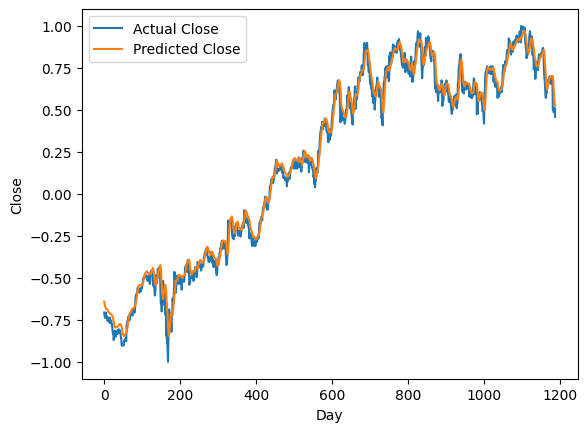

In [466]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')

plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [467]:
print(y_train.shape)
print(predicted.shape)
train_predictions = predicted.flatten()
print(train_predictions.shape)

torch.Size([1188, 1])
(1188, 1)
(1188,)


In [468]:

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([248.3161529 , 246.58759439, 244.58412582, ..., 467.20345278,
       462.7038827 , 460.32557812])

In [469]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([236.6634515 , 233.06256504, 230.80740787, ..., 454.07369736,
       457.77798648, 448.14880166])

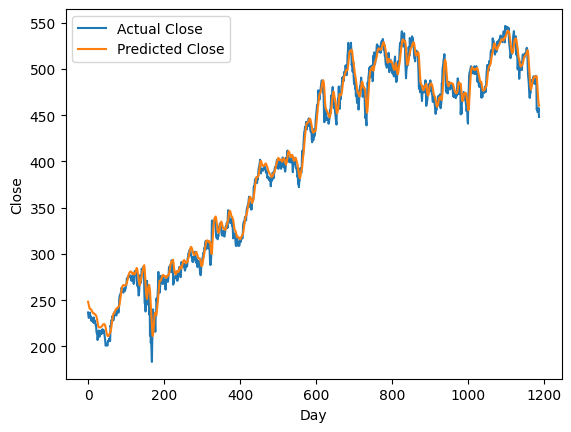

In [470]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [471]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([457.85150667, 454.9615934 , 451.23609737, 448.96077305,
       451.53381732, 457.53591572, 466.28060541, 476.33353861,
       483.82642462, 488.04461859, 490.00516428, 491.15798429,
       492.25229575, 492.06784541, 490.58206167, 489.17263583,
       489.30464292, 489.94971004, 490.90039284, 492.94252775,
       495.69251654, 498.89959124, 502.54223084, 505.44925694,
       508.06147661, 510.59257278, 513.09522699, 515.75822194,
       517.0146829 , 518.19773197, 519.02813756, 518.84782463,
       516.93155569, 513.77948033, 507.6973632 , 500.85006418,
       496.49495673, 494.6053968 , 495.48361002, 497.29068176,
       498.96249715, 498.98930364, 498.51322032, 497.65412366,
       496.53901686, 495.96710168, 495.96066812, 495.31210261,
       493.444941  , 491.45501107, 489.49616583, 489.1285757 ,
       488.57084901, 488.0261519 , 488.07470685, 491.96872096,
       494.5900819 , 496.84553151, 497.07705296, 496.29350187,
       495.23883153, 494.59867081, 495.09343745])

In [472]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([439.85400617, 437.34466387, 443.74749497, 466.90924204,
       476.96655093, 491.09661638, 499.01306665, 489.15487314,
       484.12619162, 485.24145005, 491.77374298, 493.25747968,
       486.96417069, 481.65667998, 482.06494017, 490.8875149 ,
       490.36972176, 492.29156861, 498.84374709, 501.08426087,
       504.88811852, 510.64370549, 509.57821507, 511.7091959 ,
       515.36365202, 519.0679953 , 522.41375976, 515.04503925,
       521.33831574, 519.1475808 , 514.64673267, 506.02331664,
       501.55227517, 482.67235906, 479.6153249 , 493.27737605,
       495.3386275 , 503.35461381, 500.99462429, 499.79971538,
       488.61716196, 492.90893028, 494.12377889, 490.98709425,
       495.19922291, 495.01999307, 489.23000714, 481.04998676,
       484.51999255, 482.59000085, 489.98001491, 484.49999869,
       484.0400101 , 486.43999815, 509.26001388, 494.64999848,
       498.23998904, 489.89001008, 488.01001385, 489.33999499,
       492.10998847, 500.92999627, 504.35998186])

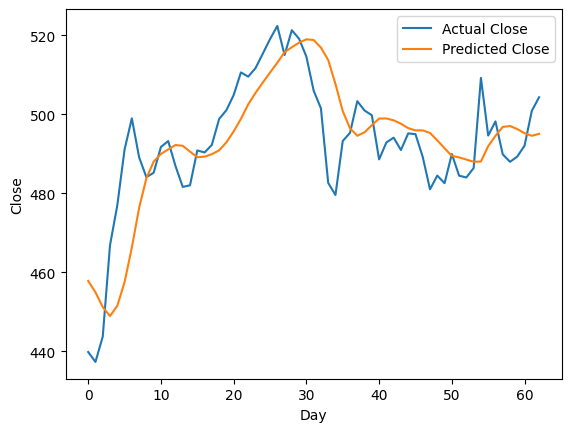

In [473]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [474]:
test_predictions

array([457.85150667, 454.9615934 , 451.23609737, 448.96077305,
       451.53381732, 457.53591572, 466.28060541, 476.33353861,
       483.82642462, 488.04461859, 490.00516428, 491.15798429,
       492.25229575, 492.06784541, 490.58206167, 489.17263583,
       489.30464292, 489.94971004, 490.90039284, 492.94252775,
       495.69251654, 498.89959124, 502.54223084, 505.44925694,
       508.06147661, 510.59257278, 513.09522699, 515.75822194,
       517.0146829 , 518.19773197, 519.02813756, 518.84782463,
       516.93155569, 513.77948033, 507.6973632 , 500.85006418,
       496.49495673, 494.6053968 , 495.48361002, 497.29068176,
       498.96249715, 498.98930364, 498.51322032, 497.65412366,
       496.53901686, 495.96710168, 495.96066812, 495.31210261,
       493.444941  , 491.45501107, 489.49616583, 489.1285757 ,
       488.57084901, 488.0261519 , 488.07470685, 491.96872096,
       494.5900819 , 496.84553151, 497.07705296, 496.29350187,
       495.23883153, 494.59867081, 495.09343745])

In [475]:

test_dates = df.index[-len(new_y_test):]

# Create dataframe with dates, actual and predicted values
test_results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': new_y_test,
    'Predicted': test_predictions
})
print("Test Results:")
print(test_results_df)



Test Results:
                        Date      Actual   Predicted
0  2024-04-11 00:00:00-04:00  439.854006  457.851507
1  2024-04-12 00:00:00-04:00  437.344664  454.961593
2  2024-04-15 00:00:00-04:00  443.747495  451.236097
3  2024-04-16 00:00:00-04:00  466.909242  448.960773
4  2024-04-17 00:00:00-04:00  476.966551  451.533817
..                       ...         ...         ...
58 2024-07-05 00:00:00-04:00  488.010014  497.077053
59 2024-07-08 00:00:00-04:00  489.339995  496.293502
60 2024-07-09 00:00:00-04:00  492.109988  495.238832
61 2024-07-10 00:00:00-04:00  500.929996  494.598671
62 2024-07-11 00:00:00-04:00  504.359982  495.093437

[63 rows x 3 columns]


In [476]:
def predict_future_dates(model, last_known_data, scaler, num_predictions):
    model.eval()
    predictions = []
    data = last_known_data
    for _ in range(num_predictions):
        input_data = torch.tensor(data.reshape(
            1, lookback, 1)).float().to(device)
        with torch.no_grad():
            pred = model(input_data).cpu().numpy().flatten()
        predictions.append(pred[0])
        data = np.append(data[1:], pred)
    predictions = np.array(predictions).reshape(-1, 1)
    dummies = np.zeros((predictions.shape[0], lookback + 1))
    dummies[:, 0] = predictions.flatten()
    predictions = scaler.inverse_transform(dummies)[:, 0]
    return predictions


# Predict future dates
num_future_predictions = 2
last_known_data = X_test[-1].cpu().numpy()
future_predictions = predict_future_dates(
    model, last_known_data, scaler, num_future_predictions)

# Create future dates
last_date = test_results_df['Date'].iloc[-1]
future_dates = pd.date_range(
    start=last_date, periods=num_future_predictions)

print(future_dates)
future_predictions

DatetimeIndex(['2024-07-11 00:00:00-04:00', '2024-07-12 00:00:00-04:00'], dtype='datetime64[ns, America/New_York]', freq='D')


array([495.09343745, 496.04343791])

In [477]:
predictions = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted'])
predictions['Percent Change'] = predictions['Predicted'].pct_change()

predictions

,Predicted,Percent Change
2024-07-11 00:00:00-04:00,495.093437,NaN
2024-07-12 00:00:00-04:00,496.043438,0.001919
